# Preprocess Continuous Data - Resting State
10/01/2023
Updated: 02/26/2024

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import emd
import re

import warnings
warnings.filterwarnings('ignore')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GitHub/LFPAnalysis')

In [3]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [4]:
subj_id = 'MS001'
subj_format = ['edf']
subj_site = ['MSSM']

# Specify root directory for data and results 
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/resting_state_proj/resting_state_ieeg/'
anat_dir = f'{base_dir}anat/'
neural_dir = f'{base_dir}preprocess/raw_data/{subj_id}'
save_dir = f'{base_dir}preprocess/clean_data/{subj_id}'

#### Import Data

In [7]:
edf_files = glob(f'{neural_dir}/*.edf')

mne_data = mne.io.read_raw_edf(edf_files[0], preload=True)
mne_data

<RawEDF | MS001_Resting_iEEG.edf, 276 x 312000 (609.4 s), ~657.2 MB, data loaded>

In [8]:
mne_data.ch_names

['LmOIF1',
 'LmOIF2',
 'LmOIF3',
 'LmOIF4',
 'LmOIF5',
 'LmOIF6',
 'LmOIF7',
 'LmOIF8',
 'LmOIF9',
 'LmOIF10',
 'LmOIF11',
 'LmOIF12',
 'RmOIF1',
 'RmOIF2',
 'RmOIF3',
 'RmOIF4',
 'RmOIF5',
 'RmOIF6',
 'RmOIF7',
 'RmOIF8',
 'RmOIF9',
 'RmOIF10',
 'RmOIF11',
 'RmOIF12',
 'LaCaS1',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'RaCaS1',
 'RaCaS2',
 'RaCaS3',
 'RaCaS4',
 'RaCaS5',
 'RaCaS6',
 'RaCaS7',
 'RaCaS8',
 'RaCaS9',
 'RaCaS10',
 'RaCaS11',
 'RaCaS12',
 'LAglT1',
 'LAglT2',
 'LAglT3',
 'LAglT4',
 'LAglT5',
 'LAglT6',
 'LAglT7',
 'LAglT8',
 'LAglT9',
 'LAglT10',
 'C59',
 'C60',
 'C61',
 'C62',
 'C63',
 'C64',
 'RAglT1',
 'RAglT2',
 'RAglT3',
 'RAglT4',
 'RAglT5',
 'RAglT6',
 'RAglT7',
 'RAglT8',
 'RAglT9',
 'RAglT10',
 'LHplT1',
 'LHplT2',
 'LHplT3',
 'LHplT4',
 'LHplT5',
 'LHplT6',
 'LHplT7',
 'LHplT8',
 'LHplT9',
 'LHplT10',
 'LHplT11',
 'LHplT12',
 'RHplT1',
 'RHplT2',
 'RHplT3',
 'RHplT4',
 'RHplT5',


# Import Anat Recon Info - check all elecs are present in data + recon sheet


In [9]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}/{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]
elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,Manual Examination,Notes
0,LaCaS1,A32sg_L,-8.952587,42.765351,7.745169,-9.250443,36.452287,-8.560293,Gray,Left ACgG anterior cingulate gyrus,Area s32,L Mid Orbital Gyrus,L CG,Left cingulate gyrus D,NaN,NaN
1,LaCaS10,A9l_L,-11.351734,49.160169,52.917875,-10.705220,54.795877,41.886395,Gray,Left SFG superior frontal gyrus,Unknown,L Superior Frontal Gyrus,L SFG,Left superior frontal gyrus 2 C,NaN,NaN
2,LaCaS11,Unknown,-11.351734,49.160169,57.714976,-10.790170,56.511473,47.589415,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,OOB,NaN
3,LaCaS12,Unknown,-11.351734,49.160169,62.112319,-10.779800,58.090865,52.761764,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,OOB,NaN
4,LaCaS2,A32sg_L,-9.352445,43.564703,12.942029,-9.498693,38.675785,-2.957526,Gray,Left ACgG anterior cingulate gyrus,Unknown,L ACC,L CG,Left cingulate gyrus E,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,RmTpT5,Unknown,40.229932,-32.373764,-14.241546,46.004548,-47.067322,-5.385297,White,Right Cerebral White Matter,Unknown,R Middle Temporal Gyrus,Unknown,Unknown,WM,NaN
124,RmTpT6,A37dl_R,43.828653,-34.771821,-11.842996,49.802904,-48.754227,-1.989788,Gray,Right Cerebral White Matter,Unknown,R Middle Temporal Gyrus,R MTG,Unknown,Right inferior middle temporal gyrus E,NaN
125,RmTpT7,A37dl_R,47.027516,-36.770202,-9.444445,53.100242,-49.935602,1.405315,White,Right MTG middle temporal gyrus,Unknown,R Middle Temporal Gyrus,R MTG,Right superior middle temporal gyrus E,WM,NaN
126,RmTpT8,A37dl_R,51.026095,-38.768583,-7.845411,57.411817,-51.317997,3.928683,Gray,Right MTG middle temporal gyrus,Unknown,R Middle Temporal Gyrus,R MTG,Right superior middle temporal gyrus F,NaN,NaN


In [10]:
elec_locs.label # pulls electrode names

0       LaCaS1
1      LaCaS10
2      LaCaS11
3      LaCaS12
4       LaCaS2
        ...   
123     RmTpT5
124     RmTpT6
125     RmTpT7
126     RmTpT8
127     RmTpT9
Name: label, Length: 128, dtype: object

### Fix edf channel names

In [11]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)

Number of electrodes in the mne file is greater than the number of electrodes in the localization file


In [12]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}
new_name_dict

{'LmOIF1': 'lmolf1',
 'LmOIF2': 'lmolf2',
 'LmOIF3': 'lmolf3',
 'LmOIF4': 'lmolf4',
 'LmOIF5': 'lmolf5',
 'LmOIF6': 'lmolf6',
 'LmOIF7': 'lmolf7',
 'LmOIF8': 'lmolf8',
 'LmOIF9': 'lmolf9',
 'LmOIF10': 'lmolf10',
 'LmOIF11': 'lmolf11',
 'LmOIF12': 'lmolf12',
 'RmOIF1': 'rmolf1',
 'RmOIF2': 'rmolf2',
 'RmOIF3': 'rmolf3',
 'RmOIF4': 'rmolf4',
 'RmOIF5': 'rmolf5',
 'RmOIF6': 'rmolf6',
 'RmOIF7': 'rmolf7',
 'RmOIF8': 'rmolf8',
 'RmOIF9': 'rmolf9',
 'RmOIF10': 'rmolf10',
 'RmOIF11': 'rmolf11',
 'RmOIF12': 'rmolf12',
 'LaCaS1': 'lacas1',
 'LaCaS2': 'lacas2',
 'LaCaS3': 'lacas3',
 'LaCaS4': 'lacas4',
 'LaCaS5': 'lacas5',
 'LaCaS6': 'lacas6',
 'LaCaS7': 'lacas7',
 'LaCaS8': 'lacas8',
 'LaCaS9': 'lacas9',
 'LaCaS10': 'lacas10',
 'LaCaS11': 'lacas11',
 'LaCaS12': 'lacas12',
 'RaCaS1': 'racas1',
 'RaCaS2': 'racas2',
 'RaCaS3': 'racas3',
 'RaCaS4': 'racas4',
 'RaCaS5': 'racas5',
 'RaCaS6': 'racas6',
 'RaCaS7': 'racas7',
 'RaCaS8': 'racas8',
 'RaCaS9': 'racas9',
 'RaCaS10': 'racas10',
 'RaCaS11': 'r

In [13]:
# Rename the mne data according to the localization data
mne_data.rename_channels(new_name_dict)

<RawEDF | MS001_Resting_iEEG.edf, 276 x 312000 (609.4 s), ~657.2 MB, data loaded>

In [14]:
unmatched_seeg #make sure there are no unmatched names

[]

In [15]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

['c59', 'c60', 'c61', 'c62', 'c63', 'c64', 'c125', 'c126', 'c127', 'c128', 'fp1', 'f7', 't3', 't5', 'o1', 'f3', 'c3', 'p3', 'fp2', 'f8', 't4', 't6', 'o2', 'f4', 'c4', 'p4', 'fz', 'cz', 'pz', 'ekg1', 'ekg2', 'c160', 'c161', 'c162', 'c163', 'c164', 'c165', 'c166', 'c167', 'c168', 'c169', 'c170', 'c171', 'c172', 'c173', 'c174', 'c175', 'c176', 'c177', 'c178', 'c179', 'c180', 'c181', 'c182', 'c183', 'c184', 'c185', 'c186', 'c187', 'c188', 'c189', 'c190', 'c191', 'c192', 'c193', 'c194', 'c195', 'c196', 'c197', 'c198', 'c199', 'c200', 'c201', 'c202', 'c203', 'c204', 'c205', 'c206', 'c207', 'c208', 'c209', 'c210', 'c211', 'c212', 'c213', 'c214', 'c215', 'c216', 'c217', 'c218', 'c219', 'c220', 'c221', 'c222', 'c223', 'c224', 'c225', 'c226', 'c227', 'c228', 'c229', 'c230', 'c231', 'c232', 'c233', 'c234', 'c235', 'c236', 'c237', 'c238', 'c239', 'c240', 'c241', 'c242', 'c243', 'c244', 'c245', 'c246', 'c247', 'c248', 'c249', 'c250', 'c251', 'c252', 'c253', 'c254', 'c255', 'c256', 'dc1', 'dc2', 'dc

In [16]:
# Note, there is surface EEG data that we should separately indicate from the sEEG:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of', len(left_seeg_names), 'left &', len(right_seeg_names), 'right sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')


We have a total of 64 left & 64 right sEEG electrodes
We have a total of 128 sEEG electrodes


In [17]:
drop_chans = list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names)) # it is either called DC1 or research
mne_data.drop_channels(drop_chans) #number of chans should = number of seegs 

<RawEDF | MS001_Resting_iEEG.edf, 128 x 312000 (609.4 s), ~304.8 MB, data loaded>

In [19]:
# Set channel types:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
mne_data.set_channel_types(sEEG_mapping_dict)


<RawEDF | MS001_Resting_iEEG.edf, 128 x 312000 (609.4 s), ~304.8 MB, data loaded>

In [20]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawEDF | MS001_Resting_iEEG.edf, 128 x 312000 (609.4 s), ~304.9 MB, data loaded>

### Notch filter line noise

In [21]:
# Identify line noise
mne_data.info['line_freq'] = 60

# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.9s finished


<RawEDF | MS001_Resting_iEEG.edf, 128 x 312000 (609.4 s), ~304.9 MB, data loaded>

### Resampling data 

In [22]:
#resampling if patient is not sampled at 512
resample_sr = 500
mne_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    2.6s finished


<RawEDF | MS001_Resting_iEEG.edf, 128 x 304688 (609.4 s), ~297.7 MB, data loaded>

### Bad Channel Removal (manual)

Let's pick out any bad channels missed by automatic screening (visual inspection as a reference), or restore channels that were erroneously deemed bad. You have to press the "power" button twice (once for the plot and once for the panel beneath it) when you're done so that you're manual changes are saved.
Update for BP preprocessing - be much less strict with channel removal. 

In [7]:
mne_data = mne.io.read_raw_fif(f'{save_dir}/{subj_id}_raw_ieeg.fif', preload=True)

<IPython.core.display.Javascript object>


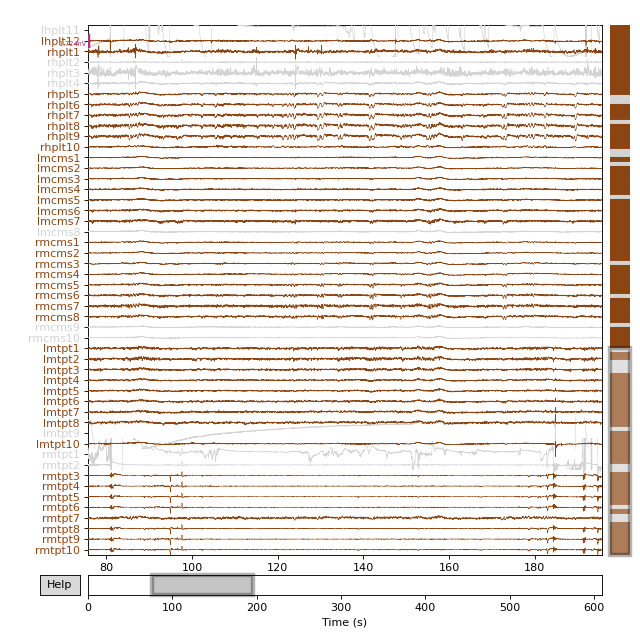

<IPython.core.display.Javascript object>


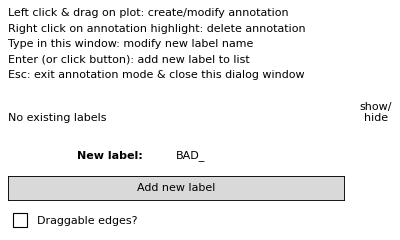

In [18]:
%matplotlib notebook

fig = mne_data.plot(start=0, duration=120, n_channels=50, scalings=mne_data._data.max()/20)
fig.fake_keypress('a')

In [19]:
mne_data.info['bads'] #sanity check that bads info saved
#len(mne_data.info['bads']) # number of bad electrodes 

['lacas10',
 'racas6',
 'rmolf6',
 'rmolf7',
 'rmolf12',
 'lagit10',
 'lhplt11',
 'rhplt2',
 'rmtpt1',
 'lagit10',
 'lhplt11',
 'lhplt5',
 'lmcms8',
 'rhplt4',
 'rmcms10',
 'rmcms9',
 'rmolf12',
 'lagit10',
 'lhplt11',
 'lhplt5',
 'lmcms8',
 'rhplt4',
 'rmcms10',
 'rmcms9',
 'rmolf12',
 'lacas7',
 'lacas8',
 'lmtpt9',
 'ragit8',
 'rhplt3',
 'rmtpt2']

## Save raw LFP data
Notch filtered and resampled with bad elecs indicated

In [20]:
mne_data.save(f'{save_dir}/{subj_id}_raw_ieeg.fif',overwrite=True)

# Rereference data 

In [21]:
# Re-reference neural data
anat_file = glob(f'{anat_dir}/{subj_id}_labels.csv')[0]

mne_data_bp_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                              elec_path=anat_file, 
                                              method='bipolar', 
                                              site='MSSM')

In [22]:
mne_data_bp_reref

<Raw | MS001_raw_ieeg.fif, 61 x 304688 (609.4 s), ~141.9 MB, data loaded>

In [23]:
mne_data_bp_reref.ch_names

['lacas1-lacas2',
 'lacas2-lacas3',
 'lacas3-lacas4',
 'lacas4-lacas5',
 'lacas5-lacas6',
 'lacas6-lacas9',
 'lagit1-lagit2',
 'lagit2-lagit3',
 'lagit3-lagit4',
 'lagit4-lagit5',
 'lagit7-lagit8',
 'lagit8-lagit9',
 'lhplt1-lhplt2',
 'lhplt2-lhplt3',
 'lhplt3-lhplt4',
 'lhplt4-lhplt6',
 'lhplt6-lhplt7',
 'lhplt7-lhplt8',
 'lhplt8-lhplt9',
 'lhplt9-lhplt10',
 'lmcms1-lmcms2',
 'lmcms2-lmcms3',
 'lmcms3-lmcms4',
 'lmcms6-lmcms7',
 'lmolf1-lmolf2',
 'lmolf3-lmolf4',
 'lmolf4-lmolf5',
 'lmolf7-lmolf8',
 'lmolf8-lmolf9',
 'lmolf9-lmolf10',
 'lmtpt1-lmtpt2',
 'lmtpt2-lmtpt3',
 'lmtpt6-lmtpt7',
 'lmtpt7-lmtpt8',
 'racas1-racas2',
 'racas3-racas4',
 'racas4-racas5',
 'racas5-racas7',
 'racas8-racas9',
 'racas9-racas10',
 'ragit1-ragit2',
 'ragit2-ragit3',
 'ragit3-ragit4',
 'rhplt1-rhplt5',
 'rhplt8-rhplt9',
 'rmcms1-rmcms2',
 'rmcms2-rmcms3',
 'rmcms3-rmcms4',
 'rmcms4-rmcms5',
 'rmcms7-rmcms8',
 'rmolf1-rmolf2',
 'rmolf3-rmolf4',
 'rmolf4-rmolf5',
 'rmolf5-rmolf8',
 'rmolf8-rmolf9',
 'rmolf

<IPython.core.display.Javascript object>


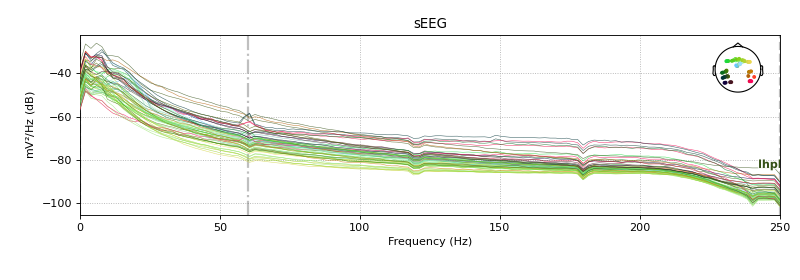

<IPython.core.display.Javascript object>


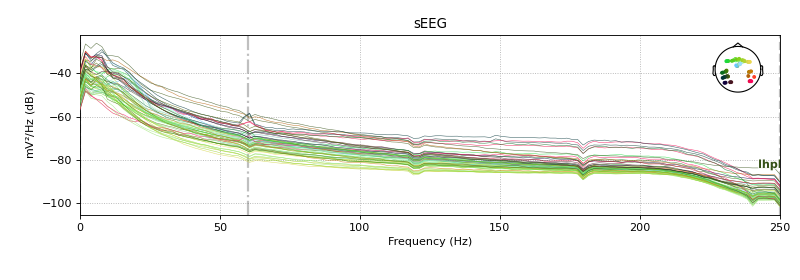

In [24]:
mne_data_bp_reref.compute_psd().plot()

To start annotating, press 'Add new label' in the bottom panel. Then left click and drag around window of interest. 

<IPython.core.display.Javascript object>


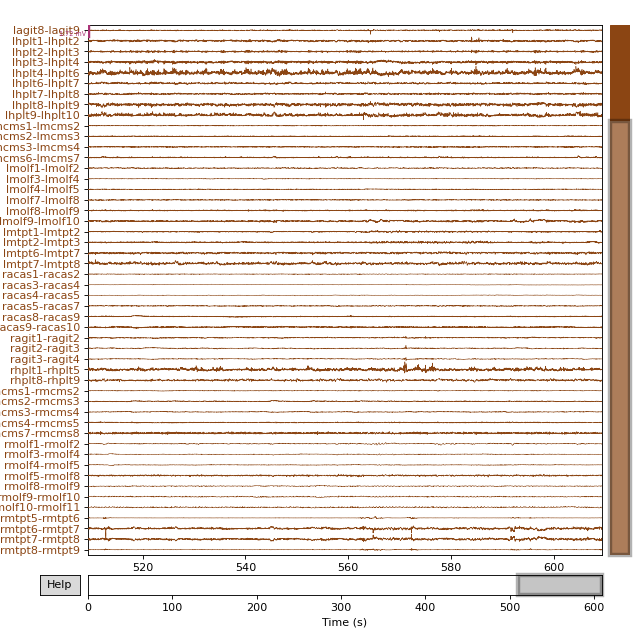

<IPython.core.display.Javascript object>


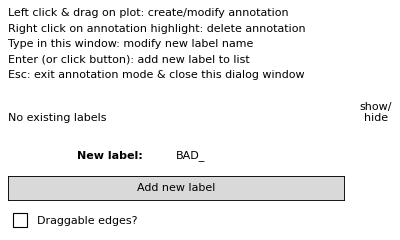

In [25]:
%matplotlib notebook

fig = mne_data_bp_reref.plot(start=2, duration=100, n_channels=50,scalings=mne_data._data.max()/20 ) # plot all channels at once
fig.fake_keypress("a")

In [222]:
# def join_good_segs(mne_data):
#     #creates indices of good epochs after labeling bad times manually, then crops good epochs and joins data 
    
#     ### get good times: 
#     good_start = list([mne_data_wm_reref.first_time]) #first timepoint in recording (should be 0)
#     good_end = []
    
#     for annot in mne_data.annotations:
#         bad_start = mne_data.time_as_index(annot['onset']) #onset is start time of bad epoch 
#         # ^ start time of bad epoch converted to index, then subtract 1 for end of good epoch
#         bad_end = mne_data.time_as_index(annot['onset'] + annot['duration']) #onset + duration = end time of bad epoch
#         # ^ end time of bad epoch converted to index 
#         # must get bad start and end as indices so you can +-1 for good epochs - cannot +-1 using time only indexes

#         good_end.append(mne_data.times[bad_start - 1]) #the start time of a bad epoch is the end of a good epoch - 1
#         good_start.append(mne_data.times[bad_end+1]) #the end time of a bad epoch is the start of a good epoch +1 index
#         #convert to integers before appending - indexing np arrays later is annoying
                          
#     good_end.append(mne_data.times[mne_data.last_samp]) #index of last timepoint in recording (should = mne_data.n_times)
    
#     ### get good data epochs and concatenate 
#     good_segs = []
#     for start,end in list(zip(good_start,good_end)):
#         good_segs.append(mne_data.copy().crop(tmin=float(start), tmax=float(end),
#                 include_tmax=True))
    
#     return mne.concatenate_raws(good_segs)
    
# #derived from: 
#     # source: https://mne.discourse.group/t/removing-time-segments-from-raw-object-without-epoching/4169/2
#     # source: https://github.com/mne-tools/mne-python/blob/maint/1.5/mne/io/base.py#L681-L742
    
    

In [26]:
# mne_data_wm_reref_clean = join_good_segs(mne_data_wm_reref)
# mne_data_wm_reref_clean

### Save reref data

In [27]:
mne_data_bp_reref.save(f'{save_dir}/{subj_id}_bp_ref_ieeg.fif',overwrite=True)